### Perform FFT

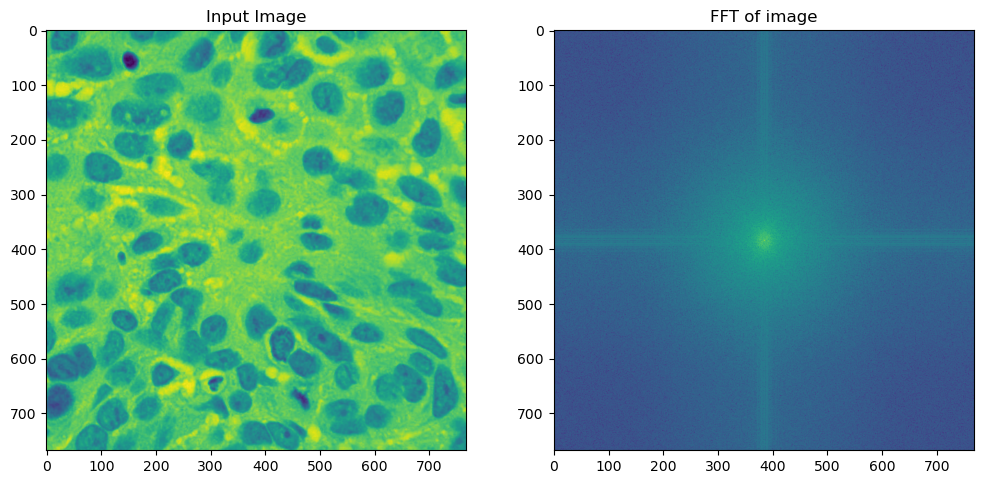

In [39]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

import cv2
from matplotlib import pyplot as plt
import numpy as np

#Generate a 2D sine wave image
x = np.arange(256)  # generate values from 0 to 255 (our image size)
y = np.sin(2 * np.pi * x / 3)  #calculate sine of x values
#Divide by a smaller number above to increase the frequency.
y += max(y) # offset sine wave by the max value to go out of negative range of sine 

#Generate a 256x256 image (2D array of the sine wave)
img = np.array([[y[j]*127 for j in range(256)] for i in range(256)], dtype=np.uint8) # create 2-D array of sine-wave

#plt.imshow(img)
#img = np.rot90(img)  #Rotate img by 90 degrees

img = cv2.imread('../Images_data/single_prediction/lung_cancer_type_1.jpeg', 0) # load an image

dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Shift DFT. First check the output without the shift
#Without shifting the data would be centered around origin at the top left
#Shifting it moves the origin to the center of the image. 
dft_shift = np.fft.fftshift(dft)

#Calculate magnitude spectrum from the DFT (Real part and imaginary part)
#Added 1 as we may see 0 values and log of 0 is indeterminate
magnitude_spectrum = 20 * np.log((cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))+1)


#As the spatial frequency increases (bars closer), 
#the peaks in the DFT amplitude spectrum move farther away from the origin

#Center represents low frequency and the corners high frequency (with DFT shift).
#To build high pass filter block center corresponding to low frequencies and let
#high frequencies go through. This is nothing but an edge filter. 

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum)
ax2.title.set_text('FFT of image')
plt.show()

C:\Users\ana220069\AppData\Local\Temp\ipykernel_27128\2115170138.py:76: RuntimeWarning: divide by zero encountered in log
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))


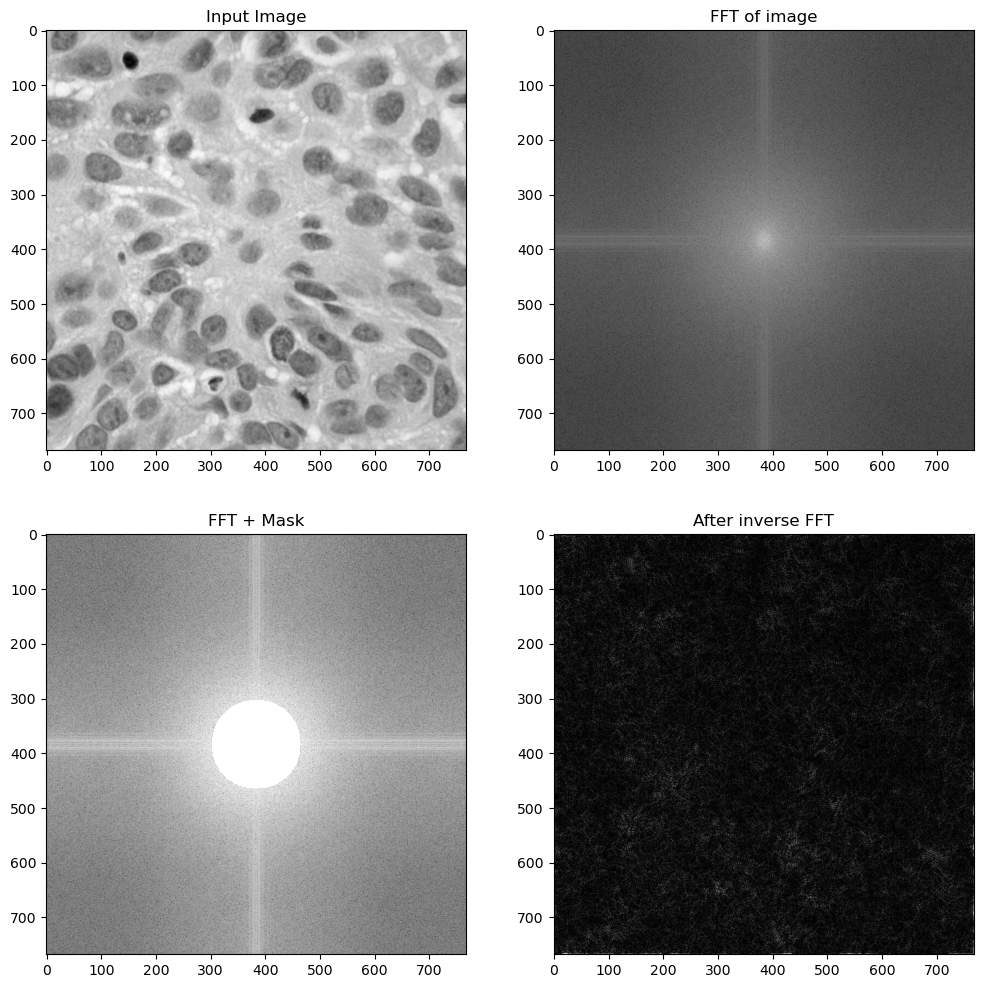

In [40]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

import cv2
from matplotlib import pyplot as plt
import numpy as np


#img = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/sandstone.tif', 0) # load an image#

#Output is a 2D complex array. 1st channel real and 2nd imaginary
#For fft in opencv input image needs to be converted to float32
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Rearranges a Fourier transform X by shifting the zero-frequency 
#component to the center of the array.
#Otherwise it starts at the tope left corenr of the image (array)
dft_shift = np.fft.fftshift(dft)

##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))


# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0


# Circular LPF mask, center circle is 1, remaining all zeros
# Only allows low frequency components - smooth regions
#Can smooth out noise but blurs edges.
#
"""
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r = 100
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

# Band Pass Filter - Concentric circle mask, only the points living in concentric circle are ones
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 80
r_in = 10
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1
"""


# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()

### Histogram Equaization

In [41]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
Histogram equalization: 
Stretches histogram to include all ranges if the original histogram is confined
only to a small region - low contrast images. 
But, this type of stretching may not result in ideal results and gives 
too bright and too dark regions in the image. This can be very bad for images
with large intensity variations. 

CLAHE: COntrast limited adaptive histogram equalization
Regular histogram equalization uses global contrast of the image. This results in
too bright and too dark regions as the histogram stretches and is not confined
to specific region.

Adaptive histogram equalization divides the image into small tiles and within 
each tile the histogram is equalized. Tile size is typically 8x8. 
If theimage contains noise, it gets amplified during this process. Therefore, 
contrast limiting is applied to limit the contrast below a specific limit.
Bilinear interpolation is performed between tile borders. 

Below, let us perform both histogram equalization and CLAHE and compare the results. 
The best way to work with color images is by converting them to luminance space,
e.g. LAB, and enhancing lumincnace channel only and eventually combining all channels. 
    
"""

import cv2
from skimage import io
from matplotlib import pyplot as plt

img = cv2.imread("../Images_data/single_prediction/lung_cancer_type_1.jpeg", 1)

#img = cv2.imread('C:/JupyterLab/github_repos/NLP_project/Images/fourier_images/retina.jpg', 1)

#Converting image to LAB Color so CLAHE can be applied to the luminance channel
lab_img= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#Splitting the LAB image to L, A and B channels, respectively
l, a, b = cv2.split(lab_img)

#plt.hist(l.flat, bins=100, range=(0,255))
###########Histogram Equlization#############
#Apply histogram equalization to the L channel
equ = cv2.equalizeHist(l)

#plt.hist(equ.flat, bins=100, range=(0,255))
#Combine the Hist. equalized L-channel back with A and B channels
updated_lab_img1 = cv2.merge((equ,a,b))

#Convert LAB image back to color (RGB)
hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)

###########CLAHE#########################
#Apply CLAHE to L channel
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
clahe_img = clahe.apply(l)
#plt.hist(clahe_img.flat, bins=100, range=(0,255))

#Combine the CLAHE enhanced L-channel back with A and B channels
updated_lab_img2 = cv2.merge((clahe_img,a,b))

#Convert LAB image back to color (RGB)
CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)

cv2.imshow("Original image", img)
cv2.imshow("Equalized image", hist_eq_img)
cv2.imshow('CLAHE Image', CLAHE_img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

### Shading correction (rolling ball)

In [42]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG


"""
1st approach: Perform CLAHE
# Equalize light by performing CLAHE on the Luminance channel
# The equalize part alreay covered as aprt of previous tutorials about CLAHE
# This kind of works but you can still see shading after the correction.

2nd approach:
Apply rolling ball background subtraction
pip install opencv-rolling-ball

"""
import cv2
import numpy as np

img = cv2.imread("../Images_data/single_prediction/lung_cancer_type_1.jpeg", 1)

lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_img)


clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(l)
CLAHE_img = cv2.merge((clahe_img,a,b))

corrected_image = cv2.cvtColor(CLAHE_img, cv2.COLOR_LAB2BGR)

cv2.imshow("Original image", img)
cv2.imshow("Corrected image", corrected_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [43]:
# TO DO: ADAPT
"""
#2nd method
# https://pypi.org/project/opencv-rolling-ball/
# 
# pip install opencv-rolling-ball
# Only works with 8 bit grey

A local background value is determined for every pixel by averaging over a 
very large ball around the pixel. This value is then subtracted from 
the original image, removing large spatial variations of the 
background intensities. The radius should be set to at least the size of the 
largest object that is not part of the background.
"""

import cv2
from cv2_rolling_ball import subtract_background_rolling_ball
from matplotlib import pyplot as plt

img = cv2.imread("../Images_data/single_prediction/lung_cancer_type_1.jpeg", 0)

radius=20
final_img, background = subtract_background_rolling_ball(img, radius, light_background=True,
                                     use_paraboloid=False, do_presmooth=True)


#optionally perform CLAHE to equalize histogram for better segmentation
#otherwise the image may appear washedout. 

clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(final_img)

#cv2.imshow("Original image", img)
cv2.imshow("Background image", background)
cv2.imshow("AFter background subtraction", final_img)
cv2.imshow("After CLAHE", clahe_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Color spaces

In [44]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""
Color spaces
RGB - Red, Green, Blue 
HSV - Hue, Saturation, Value
LAB - Lightness, A (Green to red), B (Blue to Yellow)

"""

import cv2
from skimage import io


#Needs 8 bit, not float.
color_opencv = cv2.imread('../Images_data/single_prediction/lung_cancer_type_1.jpeg', 1)
gray_opencv = cv2.imread('../Images_data/single_prediction/lung_cancer_type_1.jpeg', 0)

color_skimage = io.imread('../Images_data/single_prediction/lung_cancer_type_1.jpeg', as_gray=False)
gray_skimage = io.imread('../Images_data/single_prediction/lung_cancer_type_1.jpeg', as_gray=True)

B, G, R = cv2.split(color_opencv)


cv2.imshow("Original", color_opencv)
cv2.imshow("B", B)
cv2.imshow("G", G)
cv2.imshow("R", R)


cv2.waitKey(0)          
cv2.destroyAllWindows() 

In [45]:
##########################################################


hsv_image = cv2.cvtColor(color_skimage, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)

cv2.imshow("Original", color_opencv)
cv2.imshow("h", h)
cv2.imshow("s", s)
cv2.imshow("v", v)


cv2.waitKey(0)          
cv2.destroyAllWindows() 

#####################################


In [46]:
lab_image = cv2.cvtColor(color_skimage, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab_image)

cv2.imshow("Original", color_opencv)
cv2.imshow("L", L)
cv2.imshow("A", A)
cv2.imshow("B", B)


cv2.waitKey(0)          
cv2.destroyAllWindows() 

############################################

### Gray scale filters

In [47]:
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""

There are many filters that are designed to work with gray-scale 
images but not with color images. 
To simplify the process of creating functions that can adapt to RGB images, 
scikit-image provides the adapt_rgb decorator.

NOTE: A decorator in Python is any callable Python object that is 
used to modify a function or a class.
"""

from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

image = io.imread("../Images_data/single_prediction/lung_cancer_type_1.jpeg")

try_to_apply_sobel = filters.sobel(image)
#Fails on color images as it is a grey filter

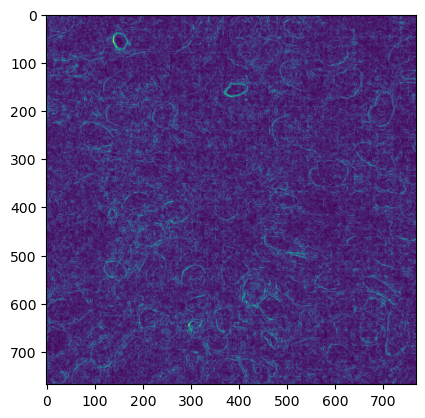

In [48]:
#Two ways to apply the filter on color images
#1. Separate R, G and B channels and apply the filter to each channel and put the channel back together.
#2. Convert RGB to HSV and then apply filter to V channel and put it back to HSV and convert to RGB.

#Too many lines of code to do these tasks but with adapt_rgb decorator the task becomes easy.

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)


each_channel_image = sobel_each(image)
hsv_value_image = sobel_hsv(image)

#Convert to grey if needed

sobel_grey = rgb2gray(hsv_value_image)

plt.imshow(sobel_grey)

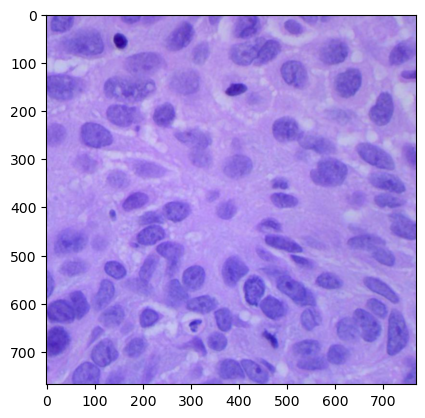

In [49]:
#################################
#The decorators work on any function, including
#the ones using opencv filters
import cv2

@adapt_rgb(each_channel)
def median_each(image, k):
    output_image = cv2.medianBlur(image, k)
    return (output_image)

median_using_cv2 = median_each(image, 3)
plt.imshow(median_using_cv2)

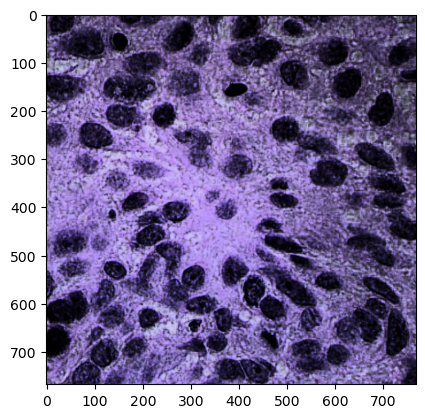

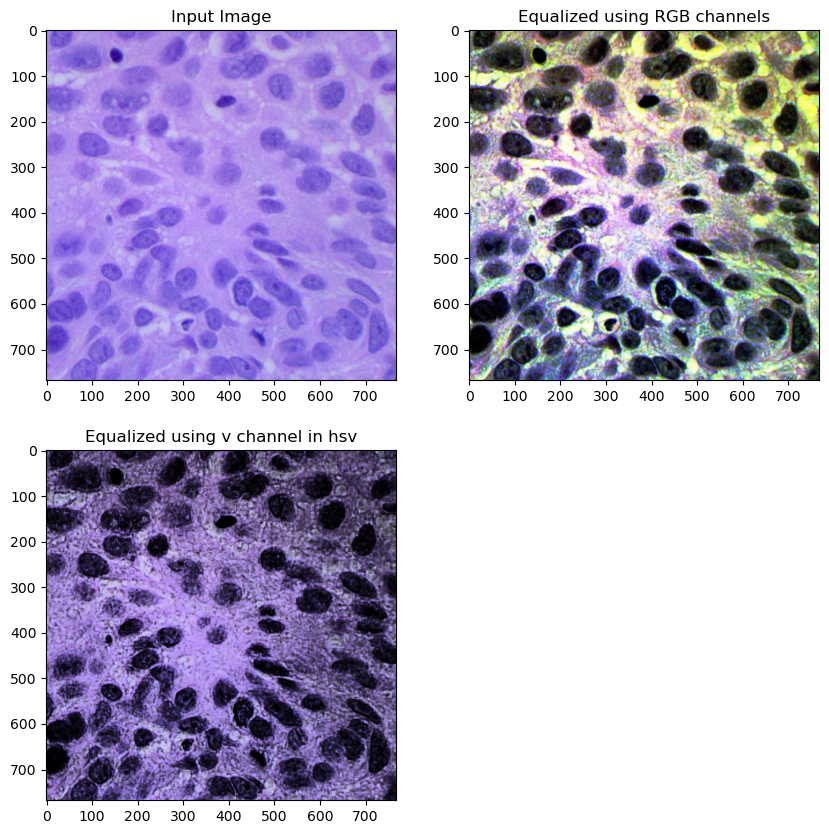

In [50]:
##############################################

#Histogram equalization on RGB channels will yield non-ideal results
#Applying it on V channel in HSV provies the best results

from skimage import exposure

@adapt_rgb(each_channel)
def eq_each(image):
    output_image = exposure.equalize_hist(image)
    return (output_image)

equ_RGB = eq_each(image)
plt.imshow(equ_RGB)


@adapt_rgb(hsv_value)
def eq_hsv(image):
    output_image = exposure.equalize_hist(image)
    return (output_image)

equ_hsv = eq_hsv(image)
plt.imshow(equ_hsv)


fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax1.title.set_text('Input Image')

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(equ_RGB)
ax2.title.set_text('Equalized using RGB channels')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(equ_hsv)
ax3.title.set_text('Equalized using v channel in hsv')

plt.show()

### No reference image quality sharpness

In [51]:
# TO DO: NEW; ADAPT
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

"""

Sharpness Estimation for Document and Scene Images
by Jayant Kumar , Francine Chen , David Doermann

http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=33CD0038A0D2D24AE2C4F1A30B6EF1A4?doi=10.1.1.359.7002&rep=rep1&type=pdf

https://github.com/umang-singhal/pydom

pip install git+https://github.com/umang-singhal/pydom.git

#Use difference of differences in grayscale values 
of a median-filtered image as an indicator of edge sharpness
"""

from dom import DOM
import cv2

#img = cv2.imread("images/image_quality_estimation/02_2sigma_blurred.tif", 1)
img1 = cv2.imread("../Images_data/single_prediction/lung_cancer_type_1.jpeg", 1)
img2 = cv2.imread("../Images_data/test_set/lung_aca/lungaca4001.jpeg", 1)
img3 = cv2.imread("../Images_data/test_set/lung_aca/lungaca4002.jpeg", 1)
img4 = cv2.imread("../Images_data/test_set/lung_aca/lungaca4003.jpeg", 1)

# initialize DOM
iqa = DOM()

#Calculate scores
score1 = iqa.get_sharpness(img1)
score2 = iqa.get_sharpness(img2)
score3 = iqa.get_sharpness(img3)
score4 = iqa.get_sharpness(img4)

print("Sharpness for reference image:", score1)
print("Sharpness for 2 sigma blurred image:", score2)
print("Sharpness for 3 sigma blurred image:", score3)
print("Sharpness for 5 sigma blurred image:", score4)


Sharpness for reference image: 0.7840547932904407
Sharpness for 2 sigma blurred image: 0.7299714217818518
Sharpness for 3 sigma blurred image: 0.6670636550028626
Sharpness for 5 sigma blurred image: 0.7601064415523723
